In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from tensorflow.keras.datasets import mnist
import cvxpy as cp
from random import random
from random import seed
import pandas as pd

In [0]:
#load data and preprocess data
(train_images , train_labels), (test_images, test_labels) = mnist.load_data()
#choose pictures of number 3 and number 5
index_train = np.where( (train_labels ==3) | (train_labels ==5) )
index_test = np.where( (test_labels ==3) | (test_labels ==5) )
#label of number 3: -1; label of number 5: +1
train_images_35 = train_images[index_train]
train_images_35 = train_images_35.reshape((len(train_images_35), train_images_35[1].size))
train_labels_35 = train_labels[index_train].astype('int')
test_images_35 = test_images[index_test]
test_images_35 = test_images_35.reshape((len(test_images_35), train_images_35[1].size))
test_labels_35 = test_labels[index_test].astype('int')
#change labels from '3' to '-1', change labels from '5' to '+1'
train_labels_35[np.where(train_labels_35==3)] = -1
train_labels_35[np.where(train_labels_35==5)] = 1
test_labels_35[np.where(test_labels_35==3)] = -1
test_labels_35[np.where(test_labels_35==5)] = 1

train_images_35=train_images_35/255 #normalizing feature vector
test_images_35=test_images_35/255

train_images_35_hw2=train_images_35[range(2000)] #choose a subset of the entire training dataset
train_labels_35_hw2=train_labels_35[range(2000)]

## 1.  Model selection

### (a)

In [0]:
# Gaussian kernel 

sigma = [0.2,0.5,1,3,4,5,10]

def kernal(sigma, size, train_or_test):
  K = np.zeros((2000, size))
  for i in range(2000):
    for j in range(size):
      K[i,j] = np.exp(-(np.linalg.norm(train_images_35_hw2[i,:]-train_or_test[j,:]))**2 / (2 * (sigma ** 2)))
  return K

In [0]:
seed(1)

################################ when sigma = 0.2

for sig in sigma:
  K = kernal(sig,2000,train_images_35_hw2)

  second_term = train_labels_35_hw2@train_labels_35_hw2.T * K

  # Define CVXPY problem.
  alpha = cp.Variable(2000)
  al_sum = cp.sum(alpha)
  prob = cp.Problem(cp.Maximize((-1/2)*cp.quad_form(alpha, second_term) + al_sum), [alpha >= np.zeros(2000), train_labels_35_hw2.T @ alpha == 0])

  prob.solve()
  optimal_alpha = alpha.value.reshape(-1,1)
  #print("The optimal alpha is", optimal_alpha)


  a_y = np.multiply(optimal_alpha,train_labels_35_hw2.reshape(-1,1))
  # find the indices of -1 label
  index = np.where(train_labels_35_hw2 == -1)[0]
  b_pos = np.amax(a_y.T @ K[:,index])
  # indices of +1 label
  index = np.where(train_labels_35_hw2 == 1)[0]
  b_neg = np.amin(a_y.T @ K[:,index])
  b = -(b_pos + b_neg)/2
  #print("The optimal b is", b)

  ####################### training error rate
  trained_labels = np.zeros(2000)
  test_training = np.add(a_y.T @ K, b)

  for i in range(2000):           ############# check if the result is zero and random assign to -1 or 1 
    trained_labels[i] = np.sign(test_training[:,i]) 
    if trained_labels[i] == 0:
      trained_labels[i] = np.sign(random()-0.5)

  ## if both 1 or -1, the reuslt will be 2 or -2 -> after abs() operation -> 2
  ## if one of them is 1 and another is -1, the result of addition is 0, therefore, we just need two array
  training_error = 1 - sum(abs(train_labels_35_hw2 + trained_labels)/2) /2000  ## since it will be double if the label matched due to abs(1+1) or abs(-1-1), we divide by 2
  print(f'Training loss is {training_error*2000} with sigma {sig} ')
  print(f'Training error is {training_error} with sigma {sig}')


  ######## Follow the same step as training error calculation for testing error calcualtion
  K_test = kernal(sig,1902,test_images_35)
  tested_labels = np.zeros(1902)
  test_testing = np.add(a_y.T @ K_test,b)

  for i in range(1902):
    tested_labels[i] = np.sign(test_testing[:,i]) 
    if tested_labels[i] == 0:
      tested_labels[i] = np.sign(random()-0.5)
  test_error = 1 - sum(abs(test_labels_35 + tested_labels)/2) / 1902
  print(f'Testing loss is {test_error*1902} with sigma {sig}')
  print(f'Testing error is {test_error} with sigma {sig}\n')

Training loss is 0.0 with sigma 0.2 
Training error is 0.0 with sigma 0.2
Testing loss is 892.0 with sigma 0.2
Testing error is 0.4689800210304942 with sigma 0.2

Training loss is 0.0 with sigma 0.5 
Training error is 0.0 with sigma 0.5
Testing loss is 892.0 with sigma 0.5
Testing error is 0.4689800210304942 with sigma 0.5

Training loss is 0.0 with sigma 1 
Training error is 0.0 with sigma 1
Testing loss is 892.0 with sigma 1
Testing error is 0.4689800210304942 with sigma 1

Training loss is 36.99999999999992 with sigma 3 
Training error is 0.01849999999999996 with sigma 3
Testing loss is 103.99999999999999 with sigma 3
Testing error is 0.05467928496319663 with sigma 3

Training loss is 173.99999999999994 with sigma 4 
Training error is 0.08699999999999997 with sigma 4
Testing loss is 177.99999999999994 with sigma 4
Testing error is 0.09358569926393268 with sigma 4

Training loss is 187.99999999999994 with sigma 5 
Training error is 0.09399999999999997 with sigma 5
Testing loss is 194

### (c)



> Perceptron Algorithm

In [0]:
#append dummy feature 1 to feature vectors, and then normalize
train_images_35_w_dummy=np.insert(train_images_35_hw2, 784, 1/255, axis=1)
test_images_35_w_dummy=np.insert(test_images_35, 784, 1/255, axis=1)

In [0]:
# initial w
w = np.ones(train_images_35_w_dummy.shape[1])

############################# Training 
correct_rate = 0
while (correct_rate < 0.95):
  correct = 0    # count the number of corrected prediction
  for i in range(2000):
    if (w.dot(train_images_35_w_dummy[i]))*train_labels_35[i] <= 0:
      w += 0.2*train_labels_35[i]*train_images_35_w_dummy[i]
            
  for i in range(2000):
    if (w.dot(train_images_35_w_dummy[i]))*train_labels_35[i] > 0:
      correct += 1
  correct_rate = correct/2000


########################### Training error
train_error_95 = 0
for i in range(2000):
  if (w.dot(train_images_35_w_dummy[i]))*train_labels_35[i] < 0:
    train_error_95 += 1
print(f'train error is {train_error_95/2000}')
print(f'train loss is {train_error_95}\n')

########################### Testing error
test_error_95 = 0
for i in range(1902):
  if (w.dot(test_images_35_w_dummy[i]))*test_labels_35[i] <= 0:
    test_error_95 += 1
print(f'test error is {test_error_95/1902}')
print(f'test loss is {test_error_95}')

train error is 0.0445
train loss is 89

test error is 0.06572029442691903
test loss is 125


> K-Nearest Neighbor

In [0]:
import pandas as pd

def euclidean_distance(array1, array2):
  return np.linalg.norm(array1 - array2)

def get_dist_test(train_data, test_data, label):         
    dist_test = np.array(np.zeros([1903,11552]))    # distance array for test data with label in the last row
    index = 0                               # index to store the distance in dist_test array
    dist = list()                   # create empty distance list
    
    for test in test_data:
        for train in train_data:
            dist.append(euclidean_distance(test, train))
        dist_test[index,] = dist
        dist = list()
        index += 1
    dist_test[-1,] = label
    return dist_test

def get_dist_train(train_data, label):         
    dist_train = np.array(np.zeros([2001,2000]))   # distance array for training data with label in the last row
    index = 0                                                # index to store the distance in dist_train array
    dist = list()                                                 # create empty distance list
    for test in train_data:
        for train in train_data:
            dist.append(euclidean_distance(test, train))
        dist_train[index,] = dist
        dist = list()
        index += 1
    dist_train[-1,] = label
    return dist_train

def predict(k_num, label_dis_arr):
    prediction = list()    # predict list
    label_with_dis = pd.DataFrame(data=np.zeros([2000,2]),columns=['label','distance'])     #data frame for label and distance
    label_with_dis['label'] = label_dis_arr[-1]        # assign label_and_diastance data frame with label
    
    for i in label_dis_arr[:-1]:
        label_with_dis['distance'] = i                               # assign dist list column to distance
        df = label_with_dis.sort_values(by='distance')                 ## sort the data base on distance                                                           
        predict_label = list(df.head(k_num)['label'])                ## select distance based on k_number and find correspond label
        
        if predict_label.count(-1) > predict_label.count(1):
            prediction.append(-1)
        else:
            prediction.append(1)
    return prediction

In [0]:
dist_label_list_training = get_dist_train(train_images_35_hw2, train_labels_35_hw2)
dist_label_list_for_testing = get_dist_test(train_images_35_hw2, test_images_35, train_labels_35_hw2)

for i in range(3,6,2):
    precd_2 = predict(i, dist_label_list_training)
    precd_2 = np.array(precd_2)
    correct_num_2 = np.equal(precd_2, train_labels_35_hw2)
    print('training error with k = {a} is {b}'.format(a=i, b=1-np.count_nonzero(correct_num_2==True)/2000))
    print('training loss with k = {a} is {b}'.format(a=i, b=2000-np.count_nonzero(correct_num_2==True)))
print('\n')

for i in range(3,6,2):
    precd = predict(i, dist_label_list_for_testing)
    precd = np.array(precd)
    correct_num = np.equal(precd, test_labels_35)
    print('test error with k = {a} is {b}'.format(a=i, b=1-np.count_nonzero(correct_num==True)/1902))
    print('test loss with k = {a} is {b}'.format(a=i, b=1902-np.count_nonzero(correct_num==True)))

training error with k = 3 is 0.009499999999999953
training loss with k = 3 is 19
training error with k = 5 is 0.010000000000000009
training loss with k = 5 is 20


test error with k = 3 is 0.02050473186119872
test loss with k = 3 is 39
test error with k = 5 is 0.02103049421661407
test loss with k = 5 is 40


> SVM

In [0]:
w = cp.Variable(784)
b = cp.Variable()
objective = cp.Minimize(cp.norm(w))
constraints = []

for i in range(2000):
  constraints.append(train_labels_35_hw2[i]*( w.T*(train_images_35_hw2[i])+b ) >=1 )

prob = cp.Problem(objective, constraints)
result = prob.solve()

optimal_w = w.value
optimal_b = b.value

################## training error
mis_clas_train = 0
for i in range(2000):
  if( (optimal_w.dot(train_images_35_hw2[i])+optimal_b) * (train_labels_35_hw2[i]) <=0 ):
    mis_clas_train += 1
training_error_rate = mis_clas_train/2000
print('training error is {}'.format(training_error_rate))
print('Training loss is {}'.format(mis_clas_train))
print('\n')
################## testing error
mis_clas_test = 0
for i in range(1902):
  if( (optimal_w.dot(test_images_35[i])+optimal_b) * (test_labels_35[i]) <=0 ):
    mis_clas_test += 1
testing_error_rate = mis_clas_test/1902
print('testing error is {}'.format(testing_error_rate))
print('Testing loss is {}'.format(mis_clas_test))

training error is 0.0
Training loss is 0


testing error is 0.06361724500525763
Testing loss is 121


## 2.  Logistic regression

#### (a)

In [0]:
from scipy.special import expit

#append dummy feature 1 to feature vectors, and then normalize
train_images_35_w_dummy=np.insert(train_images_35_hw2, 784, 1/255, axis=1)
test_images_35_w_dummy=np.insert(test_images_35, 784, 1/255, axis=1)

train_labels_35_hw3 = train_labels_35_hw2
train_labels_35_hw3[np.where(train_labels_35_hw3==-1)] = 0
test_labels_35_hw3 = test_labels_35
test_labels_35_hw3[np.where(test_labels_35_hw3==-1)] = 0

In [0]:
theta_bg = np.zeros(785)
step_siz = 0.5
B_G_D_counter = 0

while True:
  gradient = np.zeros(785)
  for i in range(2000):
    h_thet = expit(np.dot(theta_bg, train_images_35_w_dummy[i]))
    gradient += (train_labels_35_hw3[i]-h_thet)*train_images_35_w_dummy[i]

  theta_bg += step_siz*gradient
  B_G_D_counter += 1
  if (np.linalg.norm(gradient) <= 10**-2):
    break


########################### Training error
train_error = 0
for i in range(2000):
  if (expit(theta_bg.dot(train_images_35_w_dummy[i])) >= 0.5) != train_labels_35_hw3[i]:
    train_error += 1
print(f'train error is {train_error/2000}')

########################### Testing error
test_error = 0
for i in range(1902):
  if (expit(theta_bg.dot(test_images_35_w_dummy[i])) >= 0.5) != test_labels_35_hw3[i]:
    test_error += 1
print(f'test error is {test_error/1902}\n')

train error is 0.0
test error is 0.052050473186119876



In [0]:
print(f'training loss is {0}')
print(f'test loss is {0.052050473186119876*1902}')

training loss is 0
test loss is 99.0


#### (b)

In [0]:
theta_sgd = np.zeros(785)
S_G_D_count = 0    ## count how many time the whole data set is used

flag = 1
while flag:  
  shuf = np.arange(2000)
  np.random.shuffle(shuf)
  x = train_images_35_w_dummy[shuf]
  y = train_labels_35_hw3[shuf]
  for i in range(2000):
    h_thet = expit(np.dot(theta_sgd, x[i]))
    theta_sgd += 0.5*(y[i]-h_thet)*x[i]

    if ((i+1)%200 == 0):
      gra = np.zeros(785)
      for j in range(2000):
        h_thet = expit(np.dot(theta_sgd,train_images_35_w_dummy[j]))
        gra += (train_labels_35_hw3[j]-h_thet)*train_images_35_w_dummy[j]
      if np.linalg.norm(gra) <= 10**-2:
        flag = 0 
  S_G_D_count += 1

########################### Training error
train_error = 0
for i in range(2000):
  if (expit(theta_sgd.dot(train_images_35_w_dummy[i])) >= 0.5) != train_labels_35_hw3[i]:
    train_error += 1
print(f'train error is {train_error/2000}')

########################### Testing error
test_error = 0
for i in range(1902):
  if (expit(theta_sgd.dot(test_images_35_w_dummy[i])) >= 0.5) != test_labels_35_hw3[i]:
    test_error += 1
print(f'test error is {test_error/1902}')

train error is 0.0
test error is 0.06046267087276551


In [0]:
print(f'training loss is {0}')
print(f'test loss is {0.06046267087276551*1902}')

training loss is 0
test loss is 115.0


### (c)

In [0]:
print(f'batch gradient descent: the number of time the whole dataset is used before stopping is {B_G_D_counter}')
print(f'stochastic gradient descent: the number of time the whole dataset is used before stopping is {S_G_D_count}')

batch gradient descent: the number of time the whole dataset is used before stopping is 895
stochastic gradient descent: the number of time the whole dataset is used before stopping is 207


### (d)

batch gradient descent: area under curve (AUC) is 0.9339874794654353
stochastic gradient descent: area under curve (AUC) is 0.9242396661190784


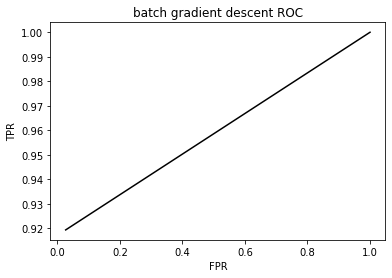

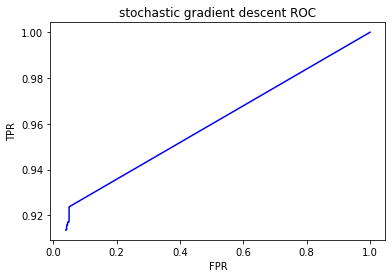

In [0]:
import matplotlib.pyplot as plt


thres = np.linspace(0,0.5,50)
TPR_b = []
FPR_b = []
TPR_s = []
FPR_s = []

for thr in thres:
  TP_b=0
  FN_b=0
  FP_b=0
  TN_b=0

  TP_s=0
  FN_s=0
  FP_s=0
  TN_s=0

  ################################################################################### batch gradient descent test error
  b_test_error = 0
  for i in range(1902):
    if (expit(theta_bg.dot(test_images_35_w_dummy[i])) >= thr) != test_labels_35_hw3[i]:
      b_test_error += 1 
      if test_labels_35_hw3[i] == 1:     ### update wrong prediction
        FN_b += 1
      else:
        FP_b += 1
    else:                   ### update true prediction
      if test_labels_35_hw3[i] == 1:
        TP_b += 1
      else:
        TN_b += 1
  #print(f'with threshold {thr}, test error is {b_test_error/1902}\n')

  ############################# TPR and FPR calculation
  TPR_b.append(TP_b/(TP_b+FN_b))
  FPR_b.append(FP_b/(FP_b+TN_b))

  ######################################################################################## stochastic gradient descent test error
  s_test_error = 0
  for i in range(1902):
    if (expit(theta_sgd.dot(test_images_35_w_dummy[i])) >= thr) != test_labels_35_hw3[i]:
      s_test_error += 1
      if test_labels_35_hw3[i] == 1:         ### update wrong prediction
        FN_s += 1
      else:
        FP_s += 1
    else:                      ### update true prediction
      if test_labels_35_hw3[i] == 1:
        TP_s += 1
      else:
        TN_s += 1
  #print(f'with threshold {thr}, test error is {s_test_error/1902}\n')

  ############################# TPR and FPR calculation
  TPR_s.append(TP_s/(TP_s+FN_s))
  FPR_s.append(FP_s/(FP_s+TN_s))

######################################################################## plot ROC
  
plt.plot(FPR_b, TPR_b,color='black')
plt.title('batch gradient descent ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.figure()
plt.plot(FPR_s, TPR_s, color='blue')
plt.title('stochastic gradient descent ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print(f'batch gradient descent: area under curve (AUC) is {abs(np.trapz(TPR_b,FPR_b))}')
print(f'stochastic gradient descent: area under curve (AUC) is {abs(np.trapz(TPR_s,FPR_s))}')

### (e)

> repeat batch gradient with the accuracy < $10^{-5}$

In [0]:
#append dummy feature 1 to feature vectors, and then normalize
train_images_35_w_dummy=np.insert(train_images_35_hw2, 784, 1/255, axis=1)
test_images_35_w_dummy=np.insert(test_images_35, 784, 1/255, axis=1)

train_labels_35_hw3 = train_labels_35_hw2
train_labels_35_hw3[np.where(train_labels_35_hw3==-1)] = 0
test_labels_35_hw3 = test_labels_35
test_labels_35_hw3[np.where(test_labels_35_hw3==-1)] = 0

theta_bg = np.zeros(785)
step_siz = 0.5
B_G_D_counter = 0

while True:
  gradient = np.zeros(785)
  for i in range(2000):
    h_thet = expit(np.dot(theta_bg, train_images_35_w_dummy[i]))
    gradient += (train_labels_35_hw3[i]-h_thet)*train_images_35_w_dummy[i]

  theta_bg += step_siz*gradient
  B_G_D_counter += 1
  if (np.linalg.norm(gradient) <= 10**-5):
    break


########################### Training error
train_error = 0
for i in range(2000):
  if (expit(theta_bg.dot(train_images_35_w_dummy[i])) >= 0.5) != train_labels_35_hw3[i]:
    train_error += 1
print(f'train error is {train_error/2000}')

########################### Testing error
test_error = 0
for i in range(1902):
  if (expit(theta_bg.dot(test_images_35_w_dummy[i])) >= 0.5) != test_labels_35_hw3[i]:
    test_error += 1
print(f'test error is {test_error/1902}\n')

train error is 0.0
test error is 0.052050473186119876



In [0]:
print(f'training loss is {0}')
print(f'test loss is {0.052050473186119876*1902}')

training loss is 0
test loss is 99.0


> repeat stochastic gradient descent with accuracy < $10^{-5}$

In [0]:
#append dummy feature 1 to feature vectors, and then normalize
train_images_35_w_dummy=np.insert(train_images_35_hw2, 784, 1/255, axis=1)
test_images_35_w_dummy=np.insert(test_images_35, 784, 1/255, axis=1)

train_labels_35_hw3 = train_labels_35_hw2
train_labels_35_hw3[np.where(train_labels_35_hw3==-1)] = 0
test_labels_35_hw3 = test_labels_35
test_labels_35_hw3[np.where(test_labels_35_hw3==-1)] = 0

theta_sgd = np.zeros(785)
S_G_D_count = 0    ## count how many time the whole data set is used

flag = 1
while flag:  
  shuf = np.arange(2000)
  np.random.shuffle(shuf)
  x = train_images_35_w_dummy[shuf]
  y = train_labels_35_hw3[shuf]
  for i in range(2000):
    h_thet = expit(np.dot(theta_sgd, x[i]))
    theta_sgd += 0.5*(y[i]-h_thet)*x[i]

    if ((i+1)%200 == 0):
      gra = np.zeros(785)
      for j in range(2000):
        h_thet = expit(np.dot(theta_sgd,train_images_35_w_dummy[j]))
        gra += (train_labels_35_hw3[j]-h_thet)*train_images_35_w_dummy[j]
      if np.linalg.norm(gra) <= 10**-5:
        flag = 0 
  S_G_D_count += 1

########################### Training error
train_error = 0
for i in range(2000):
  if (expit(theta_sgd.dot(train_images_35_w_dummy[i])) >= 0.5) != train_labels_35_hw3[i]:
    train_error += 1
print(f'train error is {train_error/2000}')

########################### Testing error
test_error = 0
for i in range(1902):
  if (expit(theta_sgd.dot(test_images_35_w_dummy[i])) >= 0.5) != test_labels_35_hw3[i]:
    test_error += 1
print(f'test error is {test_error/1902}')

> report the number of time when whole data set is used for $10^{-5}$

In [0]:
print(f'batch gradient descent: the number of time the whole dataset is used before stopping is {B_G_D_counter}')

batch gradient descent: the number of time the whole dataset is used before stopping is 30656


* Since the stochastic gradient descent with constant step size will oscillate near the local optimum, it is possible that it will never converge exactly to the minimum. In this case, since the accuracy: $10^{-5}$ is very small, it never converge to the optimum with the accuracy $10^{-5}$

## 3. K-fold

In [0]:
#load data and preprocess data
(train_images , train_labels), (test_images, test_labels) = mnist.load_data()
#choose pictures of number 3 and number 5
index_train = np.where( (train_labels ==3) | (train_labels ==5) )
index_test = np.where( (test_labels ==3) | (test_labels ==5) )
#label of number 3: -1; label of number 5: +1
train_images_35 = train_images[index_train]
train_images_35 = train_images_35.reshape((len(train_images_35), train_images_35[1].size))
train_labels_35 = train_labels[index_train].astype('int')
test_images_35 = test_images[index_test]
test_images_35 = test_images_35.reshape((len(test_images_35), train_images_35[1].size))
test_labels_35 = test_labels[index_test].astype('int')
#change labels from '3' to '-1', change labels from '5' to '+1'
train_labels_35[np.where(train_labels_35==3)] = -1
train_labels_35[np.where(train_labels_35==5)] = 1
test_labels_35[np.where(test_labels_35==3)] = -1
test_labels_35[np.where(test_labels_35==5)] = 1

train_images_35=train_images_35/255 #normalizing feature vector
test_images_35=test_images_35/255

train_images_35_hw2=train_images_35[range(2000)] #choose a subset of the entire training dataset
train_labels_35_hw2=train_labels_35[range(2000)]



# Gaussian kernel 
def kernal(sigma, size, train_or_test):
  K = np.zeros((size, size))
  for i in range(size):
    for j in range(size):
      K[i,j] = np.exp(-(np.linalg.norm(train_or_test[i]-train_or_test[j]))**2 / (2 * (sigma ** 2)))
  return K

def w_x(test_data,sigma):
  test_training = 0
  for test in range(1800):
    test_training += optimal_alpha[test]*label_choice[test]*(np.exp( -1*sigma*(np.linalg.norm(train_choice[test]-test_data)**2)  ))
  return test_training

## step 1: randomly split data
shuf = np.arange(2000)
np.random.shuffle(shuf)     ### shuffle data and label
split_train = train_images_35_hw2[shuf]
split_label = train_labels_35_hw2[shuf]
split_train = np.array(np.split(split_train, 10))   ## split data into 10
split_label = np.array(np.split(split_label, 10))
sigma = [0.2,0.5,1,3,4,5,10]

In [0]:
loss_dic = {0.2:0, 0.5:0, 1:0 ,3:0 ,4:0 ,5:0 ,10:0}
error_dic = {0.2:0, 0.5:0, 1:0 ,3:0 ,4:0 ,5:0 ,10:0}

for sig in sigma:
  total_loss = 0
  total_error = 0
  for k_f in range(10):
    train_choice = np.delete(split_train,k_f,0).reshape(-1,784)
    label_choice = np.delete(split_label,k_f,0).reshape(1800)
    K = kernal(sig,1800,train_choice)
    second_term = label_choice@label_choice.T * K

    # Define CVXPY problem.
    alpha = cp.Variable(1800)
    al_sum = cp.sum(alpha)
    prob = cp.Problem(cp.Maximize((-1/2)*cp.quad_form(alpha, second_term) + al_sum), [alpha >= np.zeros(1800), label_choice.T @ alpha == 0])

    prob.solve()
    optimal_alpha = alpha.value.reshape(-1,1)
    #print("The optimal alpha is", optimal_alpha)


    a_y = np.multiply(optimal_alpha,label_choice.reshape(-1,1))
    # find the indices of -1 label
    index = np.where(label_choice == -1)[0]
    b_pos = np.amax(a_y.T @ K[:,index])
    # indices of +1 label
    index = np.where(label_choice == 1)[0]
    b_neg = np.amin(a_y.T @ K[:,index])
    b = -(b_pos + b_neg)/2
    #print("The optimal b is", b)
    loss = 0
    ############################################################ error rate
    for test in range(200):
      if ( w_x(split_train[k_f][test],sig)+ b)*split_label[k_f][test] <=0:
        loss += 1    
    error = loss/200
    total_error += error
    total_loss += loss
    print(f'error is {error} with sigma {sig} and k-fold {k_f+1}')
  print('\n')
  error_dic[sig] = total_error/10
  loss_dic[sig] = total_loss/10


error is 0.35 with sigma 0.2 and k-fold 1
error is 0.35 with sigma 0.2 and k-fold 2
error is 0.39 with sigma 0.2 and k-fold 3
error is 0.385 with sigma 0.2 and k-fold 4
error is 0.36 with sigma 0.2 and k-fold 5
error is 0.35 with sigma 0.2 and k-fold 6
error is 0.385 with sigma 0.2 and k-fold 7
error is 0.38 with sigma 0.2 and k-fold 8
error is 0.33 with sigma 0.2 and k-fold 9
error is 0.315 with sigma 0.2 and k-fold 10


error is 0.46 with sigma 0.5 and k-fold 1
error is 0.43 with sigma 0.5 and k-fold 2
error is 0.46 with sigma 0.5 and k-fold 3
error is 0.48 with sigma 0.5 and k-fold 4
error is 0.465 with sigma 0.5 and k-fold 5
error is 0.445 with sigma 0.5 and k-fold 6
error is 0.47 with sigma 0.5 and k-fold 7
error is 0.455 with sigma 0.5 and k-fold 8
error is 0.465 with sigma 0.5 and k-fold 9
error is 0.445 with sigma 0.5 and k-fold 10


error is 0.46 with sigma 1 and k-fold 1
error is 0.43 with sigma 1 and k-fold 2
error is 0.46 with sigma 1 and k-fold 3
error is 0.48 with sigma 1

In [0]:
print('average loss with each sigma is in the foramt of {sigma:average} ')
print(loss_dic)
print('\n')
print('average error with each sigma is in the foramt of {sigma:error} ')
print(error_dic)

average loss with each sigma is in the foramt of {sigma:average} 
{0.2: 71.9, 0.5: 91.5, 1: 91.5, 3: 91.5, 4: 91.5, 5: 102.1, 10: 98.9}


average error with each sigma is in the foramt of {sigma:error} 
{0.2: 0.35950000000000004, 0.5: 0.4575, 1: 0.4575, 3: 0.4575, 4: 0.4575, 5: 0.5105, 10: 0.49449999999999994}


## 4. K-means clustering

### (1)

In [0]:
######################################  select file from local, depend on your file directory
from google.colab import files
uploaded = files.upload()

Saving hw3_data.mat to hw3_data.mat


In [0]:
from scipy.io import loadmat
hw3data = loadmat('hw3_data.mat')

In [0]:
from random import randint
######## euclidean distance function
def euclidean_distance(array1, array2):
    return np.linalg.norm(array1 - array2)

>  k = 2 with 3 initializations centroid

In [0]:
import pandas as pd
#### thress different initializations for centroid
init_centroid = [ [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]] ]
seed(1)
for i in range(3):
  init_centroid[i][0] = hw3data['X'][randint(0,599)]
  init_centroid[i][1] = hw3data['X'][randint(0,599)]
init_centroid

[[array([-4.81264373,  2.74148487]), array([ 1.58684009, -0.45082055])],
 [array([-3.41309711, -0.38223862]), array([2.65501197, 0.86251382])],
 [array([-2.28629006,  3.16501832]), array([-0.32971142, -0.71651171])]]

Text(0.5, 1.0, 'K = 2 with centroid [-2.96703433  1.978272  ] and [1.14011536 1.01137302]')

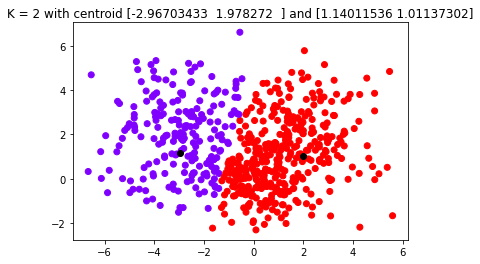

In [0]:
############  first initialized centroid for k = 2
dat_label = pd.DataFrame(data=np.zeros([600,3]),columns=['label_1','label_2','label_3'])
while 1:
  num_0 = 0
  ave_0 = 0
  num_1 = 0
  ave_1 = 0
  for i in range(600):   ############## first initializations
    c_1 = abs(euclidean_distance(init_centroid[0][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[0][1],hw3data['X'][i])) ## label 1
    if c_1 < c_2:
      dat_label.iloc[i]['label_1'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif c_1 > c_2:
      dat_label.iloc[i]['label_1'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    else:
      if randint(0,1) == 0:
        dat_label.iloc[i]['label_1'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      else:
        dat_label.iloc[i]['label_1'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1        

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  if (np.all(ave_0 == init_centroid[0][0])) and (np.all(ave_1 == init_centroid[0][1])):   ### update centroid
    break
  else:
    init_centroid[0][0] = ave_0
    init_centroid[0][1] = ave_1

plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label['label_1'],cmap='rainbow')
plt.scatter(init_centroid[0][0], init_centroid[0][1], c='black');
plt.title(f'K = {2} with centroid {init_centroid[0][0]} and {init_centroid[0][1]}')

Text(0.5, 1.0, 'K = 2 with centroid [-2.95898206  1.96834706] and [1.14631542 1.01420528]')

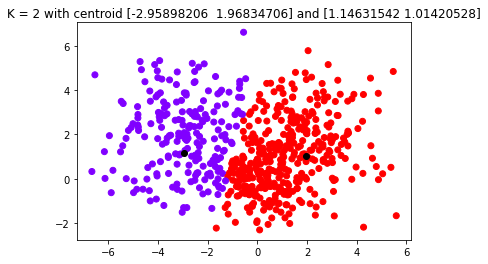

In [0]:
############  second initialized centroid for k = 2
while 1:
  num_0 = 0
  ave_0 = 0
  num_1 = 0
  ave_1 = 0
  for i in range(600):   ############## first initializations
    c_1 = abs(euclidean_distance(init_centroid[1][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[1][1],hw3data['X'][i])) ## label 1
    if c_1 < c_2:
      dat_label.iloc[i]['label_2'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif c_1 > c_2:
      dat_label.iloc[i]['label_2'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    else:
      if randint(0,1) == 0:
        dat_label.iloc[i]['label_2'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      else:
        dat_label.iloc[i]['label_2'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1        

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  if (np.all(ave_0 == init_centroid[1][0])) and (np.all(ave_1 == init_centroid[1][1])):   ### update centroid
    break
  else:
    init_centroid[1][0] = ave_0
    init_centroid[1][1] = ave_1

plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label['label_2'],cmap='rainbow')
plt.scatter(init_centroid[1][0], init_centroid[1][1], c='black');
plt.title(f'K = {2} with centroid {init_centroid[1][0]} and {init_centroid[1][1]}')

Text(0.5, 1.0, 'K = 2 with centroid [-2.96703433  1.978272  ] and [1.14011536 1.01137302]')

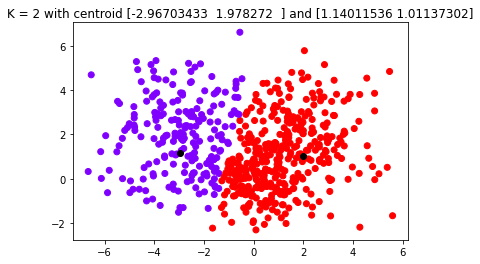

In [0]:
#### third intialization for k = 2
while 1:
  num_0 = 0
  ave_0 = 0
  num_1 = 0
  ave_1 = 0
  for i in range(600):   ############## first initializations
    c_1 = abs(euclidean_distance(init_centroid[2][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[2][1],hw3data['X'][i])) ## label 1
    if c_1 < c_2:
      dat_label.iloc[i]['label_3'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif c_1 > c_2:
      dat_label.iloc[i]['label_3'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    else:
      if randint(0,1) == 0:
        dat_label.iloc[i]['label_3'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      else:
        dat_label.iloc[i]['label_3'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1        

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  if (np.all(ave_0 == init_centroid[2][0])) and (np.all(ave_1 == init_centroid[2][1])):   ### update centroid
    break
  else:
    init_centroid[2][0] = ave_0
    init_centroid[2][1] = ave_1

plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label['label_3'],cmap='rainbow')
plt.scatter(init_centroid[2][0], init_centroid[2][1], c='black');
plt.title(f'K = {2} with centroid {init_centroid[2][0]} and {init_centroid[2][1]}')

> k = 3 with 3 initializations centroid

In [0]:
init_centroid = [ [[0,0],[0,0],[0,0]], [[0,0],[0,0],[0,0]], [[0,0],[0,0],[0,0]] ]
seed(1)
for i in range(3):
  for j in range(3):
    init_centroid[i][j] = hw3data['X'][randint(0,599)]
    init_centroid[i][j] = hw3data['X'][randint(0,599)]
dat_label_2 = pd.DataFrame(data=np.zeros([600,3]),columns=['label_1','label_2','label_3'])
init_centroid

[[array([ 1.58684009, -0.45082055]),
  array([2.65501197, 0.86251382]),
  array([-0.32971142, -0.71651171])],
 [array([ 0.49077305, -1.27577045]),
  array([3.13832119, 3.48742818]),
  array([-1.17627806, -1.59742869])],
 [array([1.55401252, 2.54272514]),
  array([-1.98338158, -0.59446302]),
  array([0.92107846, 0.45362349])]]

Text(0.5, 1.0, 'K = 3 with centroid [-0.01230902 -0.03396119] , [2.191241   2.27885438] and [-3.17316503  2.29377164]')

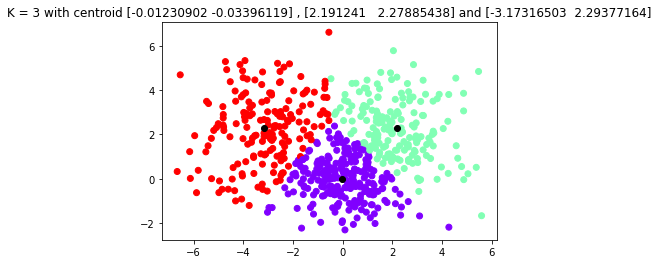

In [0]:
############## first initializations for k = 3
while 1:
  num_0 = 0
  ave_0 = 0
  num_1 = 0
  ave_1 = 0
  num_2 = 0
  ave_2 = 0
  for i in range(600):   
    c_1 = abs(euclidean_distance(init_centroid[0][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[0][1],hw3data['X'][i])) ## label 1
    c_3 = abs(euclidean_distance(init_centroid[0][2],hw3data['X'][i])) ## label 2
    if min(c_1,c_2,c_3) == c_1:
      dat_label_2.iloc[i]['label_1'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif min(c_1,c_2,c_3) == c_2:
      dat_label_2.iloc[i]['label_1'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    elif min(c_1,c_2,c_3) == c_3:
      dat_label_2.iloc[i]['label_1'] = 2
      ave_2 += hw3data['X'][i]
      num_2 += 1
    else:
      ran = randint(0,2)
      if ran == 0:
        dat_label_2.iloc[i]['label_1'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      elif ran == 1:
        dat_label_2.iloc[i]['label_1'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1 
      else:
        dat_label_2.iloc[i]['label_1'] = 2
        ave_2 += hw3data['X'][i]
        num_2 += 1             

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  ave_2 = ave_2/num_2
  if ( (np.all(ave_0 == init_centroid[0][0])) and (np.all(ave_1 == init_centroid[0][1])) and (np.all(ave_2 == init_centroid[0][2])) ):   ### update centroid
    break
  else:
    init_centroid[0][0] = ave_0
    init_centroid[0][1] = ave_1
    init_centroid[0][2] = ave_2
plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label_2['label_1'],cmap='rainbow')
plt.scatter(init_centroid[0][0][0], init_centroid[0][0][1], c='black')
plt.scatter(init_centroid[0][1][0], init_centroid[0][1][1], c='black')
plt.scatter(init_centroid[0][2][0], init_centroid[0][2][1], c='black')
plt.title(f'K = {3} with centroid {init_centroid[0][0]} , {init_centroid[0][1]} and {init_centroid[0][2]}')

Text(0.5, 1.0, 'K = 3 with centroid [-0.01230902 -0.03396119] , [2.191241   2.27885438] and [-3.17316503  2.29377164]')

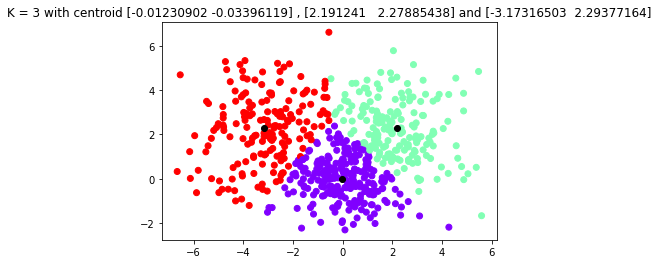

In [0]:
######################## second initializations for k = 3
while 1:
  num_0 = 0
  ave_0 = 0
  num_1 = 0
  ave_1 = 0
  num_2 = 0
  ave_2 = 0
  for i in range(600):   
    c_1 = abs(euclidean_distance(init_centroid[1][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[1][1],hw3data['X'][i])) ## label 1
    c_3 = abs(euclidean_distance(init_centroid[1][2],hw3data['X'][i])) ## label 2
    if min(c_1,c_2,c_3) == c_1:
      dat_label_2.iloc[i]['label_2'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif min(c_1,c_2,c_3) == c_2:
      dat_label_2.iloc[i]['label_2'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    elif min(c_1,c_2,c_3) == c_3:
      dat_label_2.iloc[i]['label_2'] = 2
      ave_2 += hw3data['X'][i]
      num_2 += 1
    else:
      ran = randint(0,2)
      if ran == 0:
        dat_label_2.iloc[i]['label_2'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      elif ran == 1:
        dat_label_2.iloc[i]['label_2'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1 
      else:
        dat_label_2.iloc[i]['label_2'] = 2
        ave_2 += hw3data['X'][i]
        num_2 += 1             

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  ave_2 = ave_2/num_2
  if ( (np.all(ave_0 == init_centroid[1][0])) and (np.all(ave_1 == init_centroid[1][1])) and (np.all(ave_2 == init_centroid[1][2])) ):   ### update centroid
    break
  else:
    init_centroid[1][0] = ave_0
    init_centroid[1][1] = ave_1
    init_centroid[1][2] = ave_2
plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label_2['label_2'],cmap='rainbow')
plt.scatter(init_centroid[1][0][0], init_centroid[1][0][1], c='black')
plt.scatter(init_centroid[1][1][0], init_centroid[1][1][1], c='black')
plt.scatter(init_centroid[1][2][0], init_centroid[1][2][1], c='black')
plt.title(f'K = {3} with centroid {init_centroid[1][0]} , {init_centroid[1][1]} and {init_centroid[1][2]}')

Text(0.5, 1.0, 'K = 3 with centroid [2.191241   2.27885438] , [-3.17316503  2.29377164] and [-0.01230902 -0.03396119]')

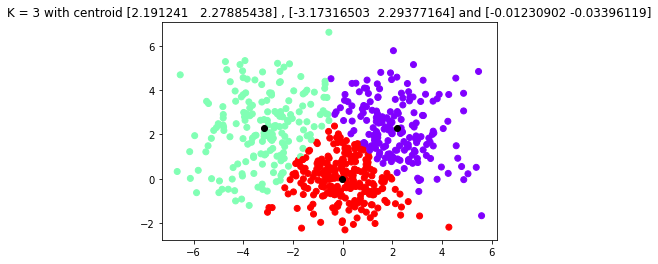

In [0]:
######################## third initializations for k = 3
while 1:
  num_0 = 0
  ave_0 = 0
  num_1 = 0
  ave_1 = 0
  num_2 = 0
  ave_2 = 0
  for i in range(600):   
    c_1 = abs(euclidean_distance(init_centroid[2][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[2][1],hw3data['X'][i])) ## label 1
    c_3 = abs(euclidean_distance(init_centroid[2][2],hw3data['X'][i])) ## label 2
    if min(c_1,c_2,c_3) == c_1:
      dat_label_2.iloc[i]['label_3'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif min(c_1,c_2,c_3) == c_2:
      dat_label_2.iloc[i]['label_3'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    elif min(c_1,c_2,c_3) == c_3:
      dat_label_2.iloc[i]['label_3'] = 2
      ave_2 += hw3data['X'][i]
      num_2 += 1
    else:
      ran = randint(0,2)
      if ran == 0:
        dat_label_2.iloc[i]['label_3'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      elif ran == 1:
        dat_label_2.iloc[i]['label_3'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1 
      else:
        dat_label_2.iloc[i]['label_3'] = 2
        ave_2 += hw3data['X'][i]
        num_2 += 1             

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  ave_2 = ave_2/num_2
  if ( (np.all(ave_0 == init_centroid[2][0])) and (np.all(ave_1 == init_centroid[2][1])) and (np.all(ave_2 == init_centroid[2][2])) ):   ### update centroid
    break
  else:
    init_centroid[2][0] = ave_0
    init_centroid[2][1] = ave_1
    init_centroid[2][2] = ave_2
plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label_2['label_3'],cmap='rainbow')
plt.scatter(init_centroid[2][0][0], init_centroid[2][0][1], c='black')
plt.scatter(init_centroid[2][1][0], init_centroid[2][1][1], c='black')
plt.scatter(init_centroid[2][2][0], init_centroid[2][2][1], c='black')
plt.title(f'K = {3} with centroid {init_centroid[2][0]} , {init_centroid[2][1]} and {init_centroid[2][2]}')

> k = 4 with 3 initializations centroid

In [0]:
init_centroid = [ [[0,0],[0,0],[0,0],[0,0]], [[0,0],[0,0],[0,0],[0,0]], [[0,0],[0,0],[0,0],[0,0]] ]
seed(1)
for i in range(3):
  for j in range(4):
    init_centroid[i][j] = hw3data['X'][randint(0,599)]
    init_centroid[i][j] = hw3data['X'][randint(0,599)]
dat_label_3 = pd.DataFrame(data=np.zeros([600,3]),columns=['label_1','label_2','label_3'])
init_centroid

[[array([ 1.58684009, -0.45082055]),
  array([2.65501197, 0.86251382]),
  array([-0.32971142, -0.71651171]),
  array([ 0.49077305, -1.27577045])],
 [array([3.13832119, 3.48742818]),
  array([-1.17627806, -1.59742869]),
  array([1.55401252, 2.54272514]),
  array([-1.98338158, -0.59446302])],
 [array([0.92107846, 0.45362349]),
  array([-2.86567839,  3.77384565]),
  array([-2.73065777,  3.03275342]),
  array([-5.29009067,  1.82169896])]]

Text(0.5, 1.0, 'K = 4 with centroid [2.25808565 0.5239578 ] , [1.536238   3.14892148] , [-3.43813488  2.35264171] and [-0.52513725  0.05421745]')

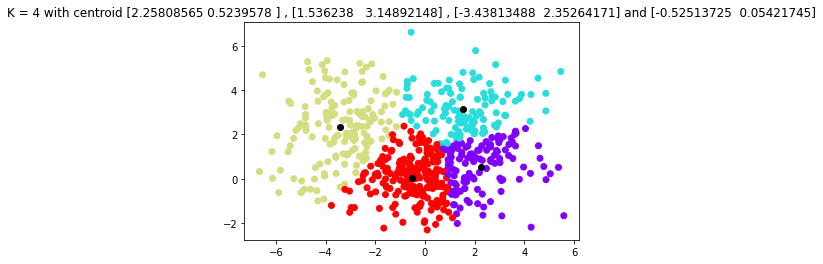

In [0]:
######################## first initializations for k = 4
while 1:
  num_0,num_1,num_2,num_3 = 0,0,0,0
  ave_0,ave_1,ave_2,ave_3 = 0,0,0,0

  for i in range(600):   
    c_1 = abs(euclidean_distance(init_centroid[0][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[0][1],hw3data['X'][i])) ## label 1
    c_3 = abs(euclidean_distance(init_centroid[0][2],hw3data['X'][i])) ## label 2
    c_4 = abs(euclidean_distance(init_centroid[0][3],hw3data['X'][i])) ## label 3
    if min(c_1,c_2,c_3,c_4) == c_1:
      dat_label_3.iloc[i]['label_1'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif min(c_1,c_2,c_3,c_4) == c_2:
      dat_label_3.iloc[i]['label_1'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    elif min(c_1,c_2,c_3,c_4) == c_3:
      dat_label_3.iloc[i]['label_1'] = 2
      ave_2 += hw3data['X'][i]
      num_2 += 1
    elif min(c_1,c_2,c_3,c_4) == c_4:
      dat_label_3.iloc[i]['label_1'] = 3
      ave_3 += hw3data['X'][i]
      num_3 += 1
    else:
      ran = randint(0,3)
      if ran == 0:
        dat_label_3.iloc[i]['label_1'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      elif ran == 1:
        dat_label_3.iloc[i]['label_1'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1 
      elif ran == 2:
        dat_label_3.iloc[i]['label_1'] = 2
        ave_2 += hw3data['X'][i]
        num_2 += 1   
      else:       
        dat_label_3.iloc[i]['label_1'] = 3
        ave_3 += hw3data['X'][i]
        num_3 += 1      

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  ave_2 = ave_2/num_2
  ave_3 = ave_3/num_3

  if ( (np.all(ave_0 == init_centroid[0][0])) and (np.all(ave_1 == init_centroid[0][1])) and (np.all(ave_2 == init_centroid[0][2])) and (np.all(ave_3 == init_centroid[0][3])) ):   ### update centroid
    break
  else:
    init_centroid[0][0] = ave_0
    init_centroid[0][1] = ave_1
    init_centroid[0][2] = ave_2
    init_centroid[0][3] = ave_3

plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label_3['label_1'],cmap='rainbow')
plt.scatter(init_centroid[0][0][0], init_centroid[0][0][1], c='black')
plt.scatter(init_centroid[0][1][0], init_centroid[0][1][1], c='black')
plt.scatter(init_centroid[0][2][0], init_centroid[0][2][1], c='black')
plt.scatter(init_centroid[0][3][0], init_centroid[0][3][1], c='black')
plt.title(f'K = {4} with centroid {init_centroid[0][0]} , {init_centroid[0][1]} , {init_centroid[0][2]} and {init_centroid[0][3]}')

Text(0.5, 1.0, 'K = 4 with centroid [2.88867599 1.86536791] , [-0.02940333 -0.17478958] , [0.35239655 2.80350805] and [-3.51725221  2.13166896]')

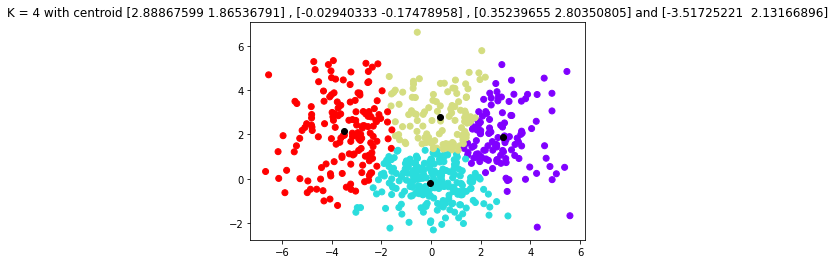

In [0]:
######################## second initializations for k = 4

while 1:
  num_0,num_1,num_2,num_3 = 0,0,0,0
  ave_0,ave_1,ave_2,ave_3 = 0,0,0,0

  for i in range(600):   
    c_1 = abs(euclidean_distance(init_centroid[1][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[1][1],hw3data['X'][i])) ## label 1
    c_3 = abs(euclidean_distance(init_centroid[1][2],hw3data['X'][i])) ## label 2
    c_4 = abs(euclidean_distance(init_centroid[1][3],hw3data['X'][i])) ## label 3
    if min(c_1,c_2,c_3,c_4) == c_1:
      dat_label_3.iloc[i]['label_2'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif min(c_1,c_2,c_3,c_4) == c_2:
      dat_label_3.iloc[i]['label_2'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    elif min(c_1,c_2,c_3,c_4) == c_3:
      dat_label_3.iloc[i]['label_2'] = 2
      ave_2 += hw3data['X'][i]
      num_2 += 1
    elif min(c_1,c_2,c_3,c_4) == c_4:
      dat_label_3.iloc[i]['label_2'] = 3
      ave_3 += hw3data['X'][i]
      num_3 += 1
    else:
      ran = randint(0,3)
      if ran == 0:
        dat_label_3.iloc[i]['label_2'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      elif ran == 1:
        dat_label_3.iloc[i]['label_2'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1 
      elif ran == 2:
        dat_label_3.iloc[i]['label_2'] = 2
        ave_2 += hw3data['X'][i]
        num_2 += 1   
      else:       
        dat_label_3.iloc[i]['label_2'] = 3
        ave_3 += hw3data['X'][i]
        num_3 += 1      

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  ave_2 = ave_2/num_2
  ave_3 = ave_3/num_3

  if ( (np.all(ave_0 == init_centroid[1][0])) and (np.all(ave_1 == init_centroid[1][1])) and (np.all(ave_2 == init_centroid[1][2])) and (np.all(ave_3 == init_centroid[1][3])) ):   ### update centroid
    break
  else:
    init_centroid[1][0] = ave_0
    init_centroid[1][1] = ave_1
    init_centroid[1][2] = ave_2
    init_centroid[1][3] = ave_3

plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label_3['label_2'],cmap='rainbow')
plt.scatter(init_centroid[1][0][0], init_centroid[1][0][1], c='black')
plt.scatter(init_centroid[1][1][0], init_centroid[1][1][1], c='black')
plt.scatter(init_centroid[1][2][0], init_centroid[1][2][1], c='black')
plt.scatter(init_centroid[1][3][0], init_centroid[1][3][1], c='black')
plt.title(f'K = {4} with centroid {init_centroid[1][0]} , {init_centroid[1][1]} , {init_centroid[1][2]} and {init_centroid[1][3]}')

Text(0.5, 1.0, 'K = 4 with centroid [2.26510115 2.27403319] , [-2.6164655   3.40313766] , [ 0.14923147 -0.01895021] and [-3.45979835  0.783049  ]')

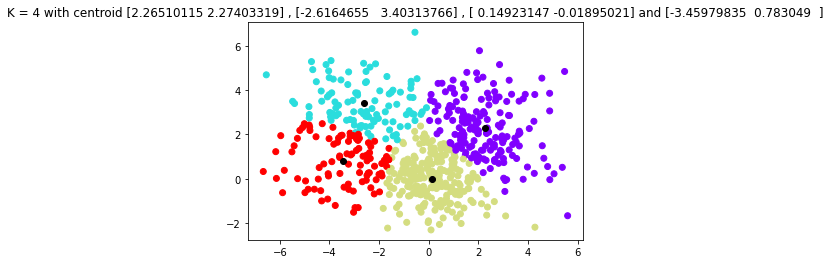

In [0]:
######################## third initializations for k = 4

while 1:
  num_0,num_1,num_2,num_3 = 0,0,0,0
  ave_0,ave_1,ave_2,ave_3 = 0,0,0,0

  for i in range(600):   
    c_1 = abs(euclidean_distance(init_centroid[2][0],hw3data['X'][i])) ## label 0
    c_2 = abs(euclidean_distance(init_centroid[2][1],hw3data['X'][i])) ## label 1
    c_3 = abs(euclidean_distance(init_centroid[2][2],hw3data['X'][i])) ## label 2
    c_4 = abs(euclidean_distance(init_centroid[2][3],hw3data['X'][i])) ## label 3
    if min(c_1,c_2,c_3,c_4) == c_1:
      dat_label_3.iloc[i]['label_3'] = 0
      ave_0 += hw3data['X'][i]
      num_0 += 1
    elif min(c_1,c_2,c_3,c_4) == c_2:
      dat_label_3.iloc[i]['label_3'] = 1
      ave_1 += hw3data['X'][i]
      num_1 += 1
    elif min(c_1,c_2,c_3,c_4) == c_3:
      dat_label_3.iloc[i]['label_3'] = 2
      ave_2 += hw3data['X'][i]
      num_2 += 1
    elif min(c_1,c_2,c_3,c_4) == c_4:
      dat_label_3.iloc[i]['label_3'] = 3
      ave_3 += hw3data['X'][i]
      num_3 += 1
    else:
      ran = randint(0,3)
      if ran == 0:
        dat_label_3.iloc[i]['label_3'] = 0
        ave_0 += hw3data['X'][i]
        num_0 += 1
      elif ran == 1:
        dat_label_3.iloc[i]['label_3'] = 1
        ave_1 += hw3data['X'][i]
        num_1 += 1 
      elif ran == 2:
        dat_label_3.iloc[i]['label_3'] = 2
        ave_2 += hw3data['X'][i]
        num_2 += 1   
      else:       
        dat_label_3.iloc[i]['label_3'] = 3
        ave_3 += hw3data['X'][i]
        num_3 += 1      

  ave_0 = ave_0/num_0
  ave_1 = ave_1/num_1
  ave_2 = ave_2/num_2
  ave_3 = ave_3/num_3

  if ( (np.all(ave_0 == init_centroid[2][0])) and (np.all(ave_1 == init_centroid[2][1])) and (np.all(ave_2 == init_centroid[2][2])) and (np.all(ave_3 == init_centroid[2][3])) ):   ### update centroid
    break
  else:
    init_centroid[2][0] = ave_0
    init_centroid[2][1] = ave_1
    init_centroid[2][2] = ave_2
    init_centroid[2][3] = ave_3

plt.figure()
plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=dat_label_3['label_3'],cmap='rainbow')
plt.scatter(init_centroid[2][0][0], init_centroid[2][0][1], c='black')
plt.scatter(init_centroid[2][1][0], init_centroid[2][1][1], c='black')
plt.scatter(init_centroid[2][2][0], init_centroid[2][2][1], c='black')
plt.scatter(init_centroid[2][3][0], init_centroid[2][3][1], c='black')
plt.title(f'K = {4} with centroid {init_centroid[2][0]} , {init_centroid[2][1]} , {init_centroid[2][2]} and {init_centroid[2][3]}')

### (2)



with k=2, centroid is 
[[ 1.14631542  1.01420528]
 [-2.95898206  1.96834706]]


with k=3, centroid is 
[[ 2.20612756  2.26636984]
 [-3.1579981   2.30624252]
 [-0.01230902 -0.03396119]]


with k=4, centroid is 
[[-2.67140418  3.37204812]
 [ 2.24684684  2.29587163]
 [-3.45327651  0.73510048]
 [ 0.16184815 -0.02135191]]




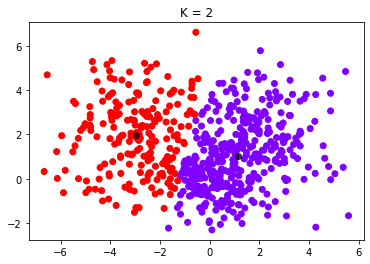

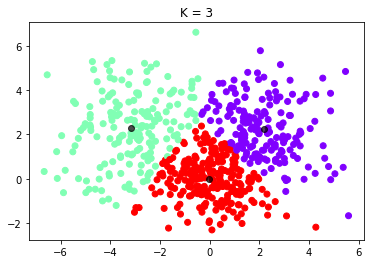

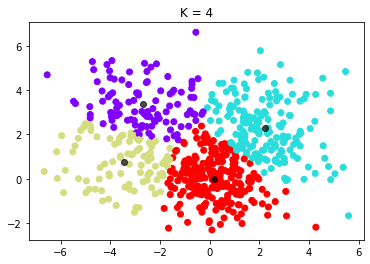

In [0]:
from sklearn.cluster import KMeans

for knum in range(2,5):
  X = hw3data['X']
  kmeans = KMeans(n_clusters=knum).fit(X)
  print(f'with k={knum}, centroid is ')
  print(kmeans.cluster_centers_)
  print('\n')
  plt.figure()
  plt.scatter(hw3data['X'][:,0],hw3data['X'][:,1],c=kmeans.labels_,cmap='rainbow')
  plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black');
  plt.title(f'K = {knum}')
